In [1]:
from sklearn.model_selection import ShuffleSplit
from skimage.feature import hog
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import cv2
import itertools
import pandas as pd
import numpy as np
import copy
import glob

import slide
import postprocess
import data
import model
import preprocess

In [2]:
def prepare_df():
    # Read in all the car and non-car classes
    vehicle_data = data.retrieve_data("vehicles")
    non_vehicle_data = data.retrieve_data("non-vehicles")

    # TODO: Ensure there is no class imbalance; fix as necessary
    df = pd.concat([vehicle_data, non_vehicle_data])
    
    # Since n_splits is 1, generator should only produce one object
    train_idx, test_idx = next(ShuffleSplit(n_splits=1, test_size=0.2, random_state=0).split(df))
    df['dataset'] = 'test'
    df['dataset'].iloc[train_idx.tolist()] = 'train'
    
    return df


In [16]:
# Train the model
import importlib
importlib.reload(model)

df = prepare_df()

COLORSPACE = 'HLS'
ORIENT = 12
PIX_PER_CELL = 8 # number of pixels to calculate the gradient
CELL_PER_BLOCK = 2 # the local area over which the histogram counts in a given cell will be normalized
# Color Bin
COLOR_BIN_SHAPE = (16, 16)
# Color Hist
NUM_HIST_BINS = 32

svc_model, le, X_scaler = model.train_model(df, COLORSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)

In [85]:
import importlib
importlib.reload(model)

image_files = glob.glob("test_images/*.jpg") + glob.glob("project_test_images/*.jpg")
heatmaps = model.get_sliding_window_preds(image_files, svc_model, X_scaler, le, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, 
                               y_start=400, y_stop=656, cell_stride=2,
                               scale=1, colorspace=COLORSPACE, spatial_size=COLOR_BIN_SHAPE, hist_bins=NUM_HIST_BINS) #le???

heatmaps += model.get_sliding_window_preds(image_files, svc_model, X_scaler, le, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, 
                               y_start=400, y_stop=656, cell_stride=2,
                               scale=1.5, colorspace=COLORSPACE, spatial_size=COLOR_BIN_SHAPE, hist_bins=NUM_HIST_BINS) #le???

heatmaps += model.get_sliding_window_preds(image_files, svc_model, X_scaler, le, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, 
                               y_start=400, y_stop=500, cell_stride=2,
                               scale=0.75, colorspace=COLORSPACE, spatial_size=COLOR_BIN_SHAPE, hist_bins=NUM_HIST_BINS) #le???


In [92]:
class RingBufSmoother(object):
        """
        Smoothes heatmaps across several iterations and applies thresholds
        """

        def __init__(self, shape, length=10, threshold=4):
            self.length = length
            self.data = np.zeros([length] + list(shape), dtype=np.float32)
            self.threshold = threshold
            self.index = 0
            self.count = 0

        def extend(self, x):
            """
            Adds array x to ring buffer.
            :param x: The element to add to the RingBuffer
            """
            self.data[self.index] = x
            self.index = (self.index + 1) % self.length
            
            self.count += 1
            if self.count > len(self.data):
                self.count = len(self.data)

        def mean(self):
            return np.mean(self.data[:self.count], axis = 0)
        
        def rolling_threshold(self):
            heatmap = self.mean() 
            heatmap[heatmap < self.threshold] = 0
            return heatmap

        
smoother = RingBufSmoother(heatmaps[0].shape)

# Extend and apply rolling threshold through the heatmaps
thresholded_heatmaps = []
for heatmap in heatmaps:
    smoother.extend(heatmap)
    thresholded_heatmaps.append(smoother.rolling_threshold())



In [98]:
importlib.reload(postprocess)

car_segmentation, num_cars = postprocess.segment_cars(thresholded_heatmaps)
car_segmentation

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 

In [99]:
importlib.reload(postprocess)

imgs_superimposed = postprocess.draw_boxes(imgs, car_segmentation, num_cars)

NameError: name 'imgs' is not defined

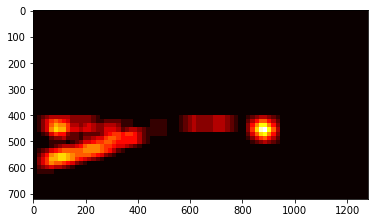

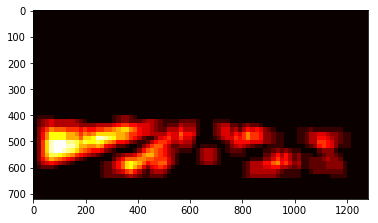

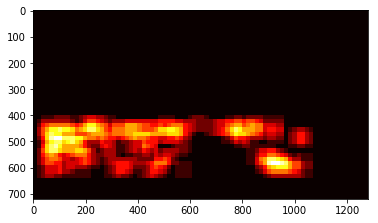

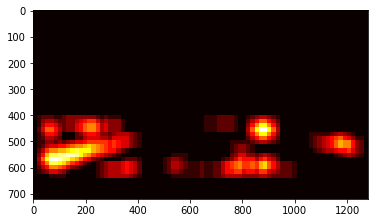

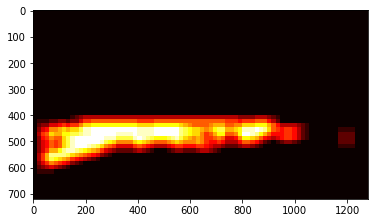

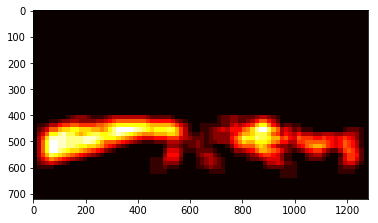

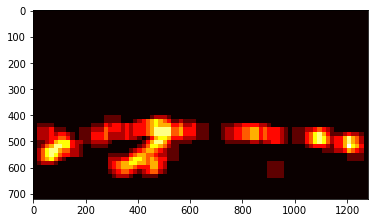

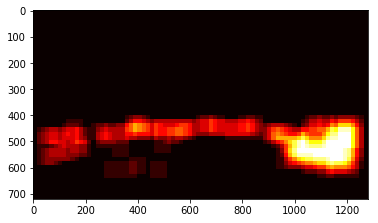

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

for heatmap in heatmaps:
    plt.imshow(np.clip(heatmap, 0, 255), cmap='hot')
    plt.show()


In [ ]:
# Perform a sliding window search for hogs data
paths = glob.glob("project_test_images/*.jpg")
paths += glob.glob("test_images/*.jpg")

ystart = 400
ystop = 656
bboxes = []

scale_and_thresholds = [(1, 7, 1)]
for scale, thres, heatscale in scale_and_thresholds:
    for path in paths:
        print('PATH: ', path)
        img = plt.imread(path)
        bboxes = []
        bboxes_sset, bbox_img = model.find_cars_hog(img, ystart, ystop, scale, svc_model, le, X_scaler, orient, pix_per_cell, cell_per_block)
        bboxes += bboxes_sset
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = postprocess.add_heat(heat,bboxes, heatscale)   
        # Apply threshold to help remove false positives
        heat = postprocess.apply_threshold(heat,thres)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = postprocess.label(heatmap)
        draw_img = postprocess.draw_labeled_bboxes(np.copy(img), labels)

        # Draw the original image, heatmap and resultant bboxes
        fig = plt.figure(figsize=(10,10))        
        plt.subplot(141).imshow(img)
        plt.subplot(142).imshow(bbox_img)
        plt.subplot(143).imshow(heatmap, cmap='hot')
        plt.subplot(144).imshow(draw_img)

        plt.show()